In [1]:
#import библиотек для нейросети

import numpy as np
from sklearn.model_selection import train_test_split
import torch
import random
from torch import nn
from torchvision import models, transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#нейросеть - построение

class MyDataset(Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x = x
        #self.y = np.block([[1 - y], [y]]).T
        self.y = y.reshape((y.shape[0], 1))
    
    def __getitem__(self, idx):
        x_transform = self.transform(self.x[idx])
        return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
    def __len__(self):
        return self.x.shape[0]

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def plot_losses(losses_train, losses_test):
    clear_output()
    plt.plot(range(1, len(losses_train) + 1), losses_train, label='train')
    plt.plot(range(1, len(losses_test) + 1), losses_test, label='test')
    plt.title('изменение качества при обучении', fontsize=14)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend()
    plt.show()

def build_cnn(ill, healthy):
    X = np.array(ill + healthy, dtype=object)
    y = np.array([0] * len(ill) + [1] * len(healthy))
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    seed_all(0)

    BATCH_SIZE = 10

    transform = T.Compose([
                       T.Resize(256),
                       T.CenterCrop(224),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                       ])

    train_dataset = MyDataset(X_train, y_train, transform)
    test_dataset = MyDataset(X_test, y_test, transform)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features=4096, out_features=1, bias=True),
        nn.Sigmoid()
      )
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99999)
    plt.rcParams['figure.figsize'] = (12, 9)
    
    NUM_EPOCHS = 30
    losses_train, losses_test = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        running_loss_train, running_loss_test = 0.0, 0.0
        model.train()
        for x, y in tqdm(train_dataloader):
        
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss_train += loss.item() * y.shape[0]
    
        losses_train += [running_loss_train / len(train_dataset)]

        model.eval()
        for x, y in tqdm(test_dataloader):
            with torch.no_grad():
            
                x = x.to(device)
                y = y.to(device)

                logits = model(x)

                loss = criterion(logits, y)
                running_loss_test += loss.item() * y.shape[0]
    
        losses_test += [running_loss_test / len(test_dataset)]
    
    return losses_train, losses_test


In [3]:
#import библиотек для изображений

import os

from PIL import Image
import pyheif

In [4]:
#чтение исходных изображений

data_ill = []
data_healthy = []


for folder in os.listdir(path="ill"):
    for file in os.listdir(path="ill/" + folder + "/"):
        try:
            heif_file = pyheif.read("ill/" + folder + "/" + file)
            image = Image.frombytes(
                heif_file.mode, 
                heif_file.size, 
                heif_file.data,
                "raw",
                heif_file.mode,
                heif_file.stride,
                ).resize((100, 150))
            data_ill.append(image)
        except:
            pass

for folder in os.listdir(path="healthy"):
    for file in os.listdir(path="healthy/" + folder + "/"):
        try:
            heif_file = pyheif.read("healthy/" + folder + "/" + file)
            image = Image.frombytes(
                heif_file.mode, 
                heif_file.size, 
                heif_file.data,
                "raw",
                heif_file.mode,
                heif_file.stride,
                ).resize((100, 150))
            data_healthy.append(image)
        except:
            pass

print(len(data_ill), " ", len(data_healthy))

203   157


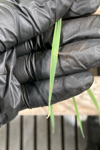

In [5]:
#демонстрация оригинальной картинки

data_ill[0]

# Эксперимент 0

Обучение нейросети на оригинальных изображениях, без фильтров

In [7]:
#обучаем нейросеть

result_train_0, result_test_0 = build_cnn(data_ill, data_healthy)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [8]:
#выводим ошибку с шагом 10

print("train :", result_train_0[9], result_train_0[19], result_train_0[29])
print("test :", result_test_0[9], result_test_0[19], result_test_0[29])

train : 0.00763559430035659 0.000894176078738248 0.0004296261249692179
test : 0.02471140456489391 0.011813570267501442 0.008212536915177933


# Эксперимент 1

Хотим повысить контрастность каждого пикселя на основе всего изображения:

1. Считаем средние значения \\( R, G, B \\) по всем пикселям изображения.

2. Далее заменяем для каждого пикселя

$$ r = r + (r - R) * coef $$
$$ g = g + (g - G) * coef $$
$$ b = b + (b - B) * coef $$

3. Коэффициент \\( coef \\) перебираем в множестве \\( \{0.5, 1\} \\)

In [9]:
#функция, повышающая контрастность на основе всего изображения

def contrast_pixel(px, mean, coef):
    res = [0, 0, 0]
    for i in range(3):
        res[i] = int(px[i] + (px[i] - mean[i]) * coef)
        res[i] = max(0, min(255, res[i]))
    return (res[0], res[1], res[2])

def more_contrast(image, coef):
    w = image.width
    h = image.height
    data = np.asarray(image)
    mean = [0, 0, 0]
    for i in range(h):
        for j in range(w):
            for k in range(3):
                mean[k] += data[i][j][k]
    mean[0] /= w * h
    mean[1] /= w * h
    mean[2] /= w * h
    data2 = []
    for i in range(h):
        for j in range(w):
            data2.append(contrast_pixel(data[i][j], mean, coef))
    img2 = Image.new("RGB", (image.size))
    img2.putdata(data2)
    return img2

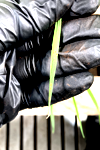

In [10]:
#пример работы функции на оригинальном изображении

more_contrast(data_ill[0], 1)

In [11]:
#применяем фильтр и обучаем нейросеть

coefs_1 = [0.5, 1]
result_train_1 = []
result_test_1 = []

for coef in coefs_1:
    temp_ill = [more_contrast(img, coef) for img in data_ill]
    temp_healthy = [more_contrast(img, coef) for img in data_healthy]
    temp_train, temp_test = build_cnn(temp_ill, temp_healthy)
    result_train_1.append(temp_train)
    result_test_1.append(temp_test)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [12]:
#выводим ошибку с шагом 10

for i in range(len(result_train_1)):
    print("train (coef = ", coefs_1[i], ") : ", sep="", end="")
    print(result_train_1[i][9], result_train_1[i][19], result_train_1[i][29], sep="")

    print("test (coef = ", coefs_1[i], ") : ", sep="", end="")
    print(result_test_1[i][9], result_test_1[i][19], result_test_1[i][29], sep="")
    print()

train (coef = 0.5) : 0.0089575943873367380.00097465316664763830.000403193563821939
test (coef = 0.5) : 0.0295293262331850.0124976370069715720.00822337511656062

train (coef = 1) : 0.0109894068790944640.00095891777810821730.0003019577447115875
test (coef = 1) : 0.038187863175860710.0213689232882138120.016718126224683754



# Эксперимент 2

Хотим повысить контрастность зеленой составляющей каждого пикселя на основе всего изображения:

1. Считаем среднее значение \\( G \\) по всем пикселям изображения.

2. Далее заменяем для каждого пикселя

$$ g = g + (g - G) * coef $$

3. Коэффициент \\( coef \\) перебираем в множестве \\( \{0.5, 1\} \\)

In [13]:
#функция, повышающая контрастность зеленого на основе всего изображения

def green_contrast_pixel(px, mean, coef):
    new_g = int(px[1] + (px[1] - mean) * coef)
    return (px[0], new_g, px[2])

def more_green_contrast(image, coef):
    w = image.width
    h = image.height
    data = np.asarray(image)
    mean = 0
    for i in range(h):
        for j in range(w):
            mean += data[i][j][1]
    mean /= w * h
    data2 = []
    for i in range(h):
        for j in range(w):
            data2.append(green_contrast_pixel(data[i][j], mean, coef))
    img2 = Image.new("RGB", (image.size))
    img2.putdata(data2)
    return img2

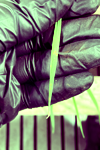

In [14]:
#пример работы функции на оригинальном изображении

more_green_contrast(data_ill[0], 1)

In [16]:
#применяем фильтр и обучаем нейросеть

coefs_2 = [0.5, 1]
result_train_2 = []
result_test_2 = []

for coef in coefs_2:
    temp_ill = [more_green_contrast(img, coef) for img in data_ill]
    temp_healthy = [more_green_contrast(img, coef) for img in data_healthy]
    temp_train, temp_test = build_cnn(temp_ill, temp_healthy)
    result_train_2.append(temp_train)
    result_test_2.append(temp_test)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [18]:
#выводим ошибку с шагом 10

for i in range(len(result_train_2)):
    print("train (coef = ", coefs_2[i], ") : ", sep="", end="")
    print(result_train_2[i][9], result_train_2[i][19], result_train_2[i][29], sep="")

    print("test (coef = ", coefs_2[i], ") : ", sep="", end="")
    print(result_test_2[i][9], result_test_2[i][19], result_test_2[i][29], sep="")
    print()

train (coef = 0.5) : 0.0135962813575234670.00150370214800609070.00056793239599318
test (coef = 0.5) : 0.036507430667471560.0267675443125578280.0283282639170971

train (coef = 1) : 0.0147983264350504790.00188943964894860980.000496192327571205
test (coef = 1) : 0.0366500103328790960.0277036881307140.027145969925590582



# Эксперимент 3

Хотим повысить контрастность зеленой составляющей пикселей, в которых она "главная" и нет.

А именно, ко всем пикселям, для которых верно \\( g \leq max(r, b) \\), применяем \\( g = 0 \\)

In [19]:
#функция-фильтр

def green_check(r, g, b):
    if (g > r and g > b):
        return (r, g, b)
    return (r, 0, b)

def less_green(img):
    now = list(img.getdata())
    now2 = [green_check(px[0], px[1], px[2]) for px in now]
    img_ans = Image.new("RGB", img.size)
    img_ans.putdata(now2)
    return img_ans

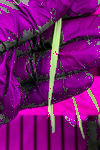

In [20]:
#пример работы функции на оригинальном изображении

less_green(data_ill[0])

In [21]:
#применяем фильтр и обучаем нейросеть

temp_ill = [less_green(img) for img in data_ill]
temp_healthy = [less_green(img) for img in data_healthy]

result_train_3, result_test_3 = build_cnn(temp_ill, temp_healthy)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [22]:
#выводим ошибку с шагом 10

print("train :", result_train_3[9], result_train_3[19], result_train_3[29])
print("test :", result_test_3[9], result_test_3[19], result_test_3[29])

train : 0.008903591451666283 0.0011784259886890478 0.0003134391832915113
test : 0.01908880927496486 0.004877500850448592 0.0025646882810785123


# Эксперимент 4

Хочется перевести в цветовую модель HSV. Переводим каждый пиксель из \\( R, G, B \\) по формулам с википедии:

\\( H = \\)
  - \\( 0 \\), если \\(MAX = MIN\\)
  - \\( 60\cdot \frac{G - B}{MAX - MIN} \\), если \\( MAX = R, G \leq B \\)
  - \\( 60\cdot \frac{G - B}{MAX - MIN} + 360 \\), если \\( MAX = R, G < B \\)
  - \\( 60\cdot \frac{B - R}{MAX - MIN} + 120 \\), если \\( MAX = G \\)
  - \\( 60\cdot \frac{R - G}{MAX - MIN} + 240 \\), если \\( MAX = B \\)

\\( S = \\)
  - \\( 0 \\), если \\( MAX = 0 \\)
  - \\( 1 - \frac{MIN}{MAX} \\), иначе

\\( V = MAX \\)

Т.к. \\(H\\) - число от \\(0\\) до \\(360\\), \\(S, V\\) - от \\(0\\) до \\(1\\), нормируем все числа в целые \[0; 255\], чтобы пользоваться RGB-системой и тем же построением сети

In [23]:
#перевод RGB в HSV

def rgb_to_hsv(px):
    r = px[0] / 255
    g = px[1] / 255
    b = px[2] / 255
    
    mx = max(r, g, b)
    mn = min(r, g, b)
    
    h, s, v = 0, 0, mx
    if mx != mn and mx == r and g >= b:
        h = 60 * (g - b) / (mx - mn)
    elif mx != mn and mx == r and g < b:
        h = 60 * (g - b) / (mx - mn) + 360
    elif mx != mn and mx == g:
        h = 60 * (b - r) / (mx - mn) + 120
    elif mx != mn and mx == b:
        h = 60 * (r - g) / (mx - mn) + 240
    
    if mx != 0:
        s = 1 - mn / mx

    return (h, s, v)

#нормировка HSV в RGB для удобства пользования изображениями

def converted_hsv(px):
    h, s, v = rgb_to_hsv(px)

    r = int(h / 360 * 255)
    g = int(s * 255)
    b = int(v * 255)
    return (r, g, b)

#перевод картинки в HSV

def image_to_hsv(img):
    w = img.width
    h = img.height
    img2 = img.copy()
    for i in range(w):
        for j in range(h):
            img2.putpixel((i, j), converted_hsv(img.getpixel((i, j))))
    return img2

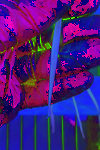

In [24]:
#пример работы функции на оригинальном изображении

image_to_hsv(data_ill[0])

In [25]:
#применяем фильтр и обучаем нейросеть

temp_ill = [image_to_hsv(img) for img in data_ill]
temp_healthy = [image_to_hsv(img) for img in data_healthy]

result_train_4, result_test_4 = build_cnn(temp_ill, temp_healthy)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [26]:
#выводим ошибку с шагом 10

print("train :", result_train_4[9], result_train_4[19], result_train_4[29])
print("test :", result_test_4[9], result_test_4[19], result_test_4[29])

train : 0.007806576888671973 0.0008782307623833832 0.00015602049614716197
test : 0.0941572280975783 0.08768643471719567 0.08778096933868558


# Эксперимент 5

Хочется перевести в цветовую модель HSV. Переводим каждый пиксель из \\( R, G, B \\) по формулам с википедии, предварительно нормируя R, G, B в \[0; 1\]:

\\( H = \\)
  - \\( 0 \\), если \\(MAX = MIN\\)
  - \\( 60\cdot \frac{G - B}{MAX - MIN} \\), если \\( MAX = R, G \geq B \\)
  - \\( 60\cdot \frac{G - B}{MAX - MIN} + 360 \\), если \\( MAX = R, G < B \\)
  - \\( 60\cdot \frac{B - R}{MAX - MIN} + 120 \\), если \\( MAX = G \\)
  - \\( 60\cdot \frac{R - G}{MAX - MIN} + 240 \\), если \\( MAX = B \\)

\\(L = \frac{MAX + MIN}{2} \\)

\\( S = \\)
  - \\( 0 \\), если \\( L = 0 \\) или \\( MAX = 0 \\)
  - \\( \frac{MAX - MIN}{MAX + MIN} \\), если \\( 0 < L \leq \frac 12 \\)
  - \\( \frac{MAX - MIN}{2 - (MAX + MIN)} \\), если \\( \frac{1}{2} < L \leq 1 \\)

Т.к. \\(H\\) - число от \\(0\\) до \\(360\\), \\(S, L\\) - от \\(0\\) до \\(1\\), нормируем все числа в целые \[0; 255\], чтобы пользоваться RGB-системой и тем же построением сети

In [27]:
#перевод из RGB в HSL

def rgb_to_hsl(px):
    r = px[0] / 255
    g = px[1] / 255
    b = px[2] / 255
    
    mx = max(r, g, b)
    mn = min(r, g, b)
    
    h, s, l = 0, 0, 0
    if mx != mn and mx == r and g >= b:
        h = 60 * (g - b) / (mx - mn)
    elif mx != mn and mx == r and g < b:
        h = 60 * (g - b) / (mx - mn) + 360
    elif mx != mn and mx == g:
        h = 60 * (b - r) / (mx - mn) + 120
    elif mx != mn and mx == b:
        h = 60 * (r - g) / (mx - mn) + 240
    
    if mx == mn:
        s = 0
    else:
        s = (mx - mn) / abs(1 - abs(1 - (mx + mn)))
    l = (mx + mn) / 2

    return (h, s, l)

#конвертация изображения в HSL

def converted_hsl(px):
    h, s, l = rgb_to_hsl(px)
    r = int(h / 360 * 255)
    g = int(s * 255)
    b = int(l * 255)
    return (r, g, b)

def image_to_hsl(img):
    w = img.width
    h = img.height
    img2 = img.copy()
    for i in range(w):
        for j in range(h):
            img2.putpixel((i, j), converted_hsl(img.getpixel((i, j))))
    return img2

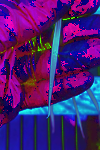

In [32]:
#пример работы функции на оригинальном изображении

image_to_hsl(data_ill[0])

In [33]:
#применяем фильтр и обучаем нейросеть

temp_ill = [image_to_hsl(img) for img in data_ill]
temp_healthy = [image_to_hsl(img) for img in data_healthy]

result_train_5, result_test_5 = build_cnn(temp_ill, temp_healthy)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [34]:
#выводим ошибку с шагом 10

print("train :", result_train_5[9], result_train_5[19], result_train_5[29])
print("test :", result_test_5[9], result_test_5[19], result_test_5[29])

train : 0.007516270299674943 0.0008520816899598921 0.00017979522032907913
test : 0.08336188851939773 0.09165888726460657 0.10160339906527345


# Эксперимент 6

Хочется выделять куски изображения зеленого цвета. По HSV можно измерить близость цвета к зеленому как близость числа H пикселя к 120. У недостаточно зеленых кусков будем понижать яркость.

Очень светлые (с маленьким \\(V\\)) пиксели тоже вряд ли можно считать зелеными, поэтому добавим отсечение по \\(V\\) тоже. То есть для каждого пикселя:

1. Переведем в HSV модель
2. Если \\( |H - 120| \leq dist \\) и \\( V \geq light \\), то оставим его как есть
3. Иначе умножим \\(R, G, B\\) на \\( coef \\)

In [41]:
#затемняем цвета, далекие от зеленого в системе HSV

def green_based_rgb(px, coef, dist, light):
    h, s, v = rgb_to_hsv(px)
    if 120 - dist <= h and h <= 120 + dist and s > light:
        return (px[0], px[1], px[2])
    return (int(px[0] // coef), int(px[1] // coef), int(px[2] // coef))

def to_green_based_hsv(img, coef, dist, light):
    w = img.width
    h = img.height
    img2 = img.copy()
    for i in range(w):
        for j in range(h):
            img2.putpixel((i, j), green_based_rgb(img.getpixel((i, j)), coef, dist, light))
    return img2

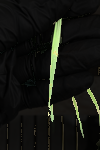

In [42]:
to_green_based_hsv(data_ill[0], 10, 80, 0.25)

Перебираем параметры \\( light \\) с фиксированными \\( coef = 2, dist = 80 \\)

In [43]:
#применяем фильтр и обучаем нейросеть

lights_6 = [0, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
light_result_train_6 = []
light_result_test_6 = []

for lig in lights_6:
    temp_ill = [to_green_based_hsv(img, 2, 80, lig) for img in data_ill]
    temp_healthy = [to_green_based_hsv(img, 2, 80, lig) for img in data_healthy]
    
    temp_train, temp_test = build_cnn(temp_ill, temp_healthy)
    light_result_train_6.append(temp_train)
    light_result_test_6.append(temp_test)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [45]:
#выводим ошибку с шагом 10

for i in range(len(light_result_train_6)):
    print("train (light = ", lights_6[i], ") : ", sep="", end="")
    print(light_result_train_6[i][9], light_result_train_6[i][19], light_result_train_6[i][29])

    print("test (light = ", lights_6[i], ") : ", sep="", end="")
    print(light_result_test_6[i][9], light_result_test_6[i][19], light_result_test_6[i][29])
    print()

train (light = 0) : 0.010487141570559255 0.0013262631430363938 0.0002525697539197238
test (light = 0) : 0.03807766021539768 0.02146723221004423 0.01705879531800747

train (light = 0.1) : 0.012169604232810714 0.0020342956526696477 0.0003880123179071773
test (light = 0.1) : 0.058064794478317104 0.04652022118494238 0.044020274377039134

train (light = 0.2) : 0.00997358623943809 0.0009990728188616533 0.0004993440008412883
test (light = 0.2) : 0.02564096280063192 0.014611154765589163 0.013271821796984619

train (light = 0.25) : 0.009598035119577415 0.0012933043555541964 0.00035962717002904456
test (light = 0.25) : 0.01738708812950386 0.006940117361308593 0.005666619242725169

train (light = 0.3) : 0.009515678307420953 0.0013505235606485425 0.0004309755612565722
test (light = 0.3) : 0.018325696789866522 0.0071170714598136125 0.0043310715839955565

train (light = 0.35) : 0.008518451969225512 0.0011780944079402144 0.0005540729210527692
test (light = 0.35) : 0.02085745707154274 0.00842031452096

Перебираем параметры \\( coef \\) с фиксированными \\( light = 0.3, dist = 80 \\)

In [46]:
#применяем фильтр и обучаем нейросеть

coefs_6 = [1.5, 2, 2.5]
coef_result_train_6 = []
coef_result_test_6 = []

for coef in coefs_6:
    temp_ill = [to_green_based_hsv(img, coef, 80, 0.3) for img in data_ill]
    temp_healthy = [to_green_based_hsv(img, coef, 80, 0.3) for img in data_healthy]
    
    temp_train, temp_test = build_cnn(temp_ill, temp_healthy)
    coef_result_train_6.append(temp_train)
    coef_result_test_6.append(temp_test)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [47]:
#выводим ошибку с шагом 10

for i in range(len(coef_result_train_6)):
    print("train (coef = ", coefs_6[i], ") : ", sep="", end="")
    print(coef_result_train_6[i][9], coef_result_train_6[i][19], coef_result_train_6[i][29], sep="")

    print("test (coef = ", coefs_6[i], ") : ", sep="", end="")
    print(coef_result_test_6[i][9], coef_result_test_6[i][19], coef_result_test_6[i][29], sep="")
    print()

train (coef = 1.5) : 0.0074408419939033960.00102057582262204960.00038145492915107215
test (coef = 1.5) : 0.0171875252983429360.0065295724246728540.003951375219912734

train (coef = 2) : 0.0095156783074209530.00135052356064854250.0004309755612565722
test (coef = 2) : 0.0183256967898665220.00711707145981361250.0043310715839955565

train (coef = 2.5) : 0.0108879640638069420.00159855338360001850.0004929187528398836
test (coef = 2.5) : 0.0235796343897365850.0115583322395751660.007656896616228753



Перебираем параметры \\( dist \\) с фиксированными \\( light = 0.3, coef = 1.5 \\)

In [48]:
#применяем фильтр и обучаем нейросеть

dists_6 = [20, 30, 40, 50, 60, 70, 80, 90]
dist_result_train_6 = []
dist_result_test_6 = []

for dist in dists_6:
    temp_ill = [to_green_based_hsv(img, 1.5, dist, 0.3) for img in data_ill]
    temp_healthy = [to_green_based_hsv(img, 1.5, dist, 0.3) for img in data_healthy]
    
    temp_train, temp_test = build_cnn(temp_ill, temp_healthy)
    dist_result_train_6.append(temp_train)
    dist_result_test_6.append(temp_test)

/tmp/ipykernel_311388/4014727116.py:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(ill + healthy, dtype=object)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/27 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
/tmp/ipykernel_311388/4014727116.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_transform, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [49]:
#выводим ошибку с шагом 10

for i in range(len(dist_result_train_6)):
    print("train (dist = ", dists_6[i], ") : ", sep="", end="")
    print(dist_result_train_6[i][9], dist_result_train_6[i][19], dist_result_train_6[i][29], sep="")

    print("test (dist = ", dists_6[i], ") : ", sep="", end="")
    print(dist_result_test_6[i][9], dist_result_test_6[i][19], dist_result_test_6[i][29], sep="")
    print()

train (dist = 20) : 0.0071339350025583470.00099625932900245830.0003820759040401619
test (dist = 20) : 0.018144009266203890.0093569129789506810.005839563607272187

train (dist = 30) : 0.0057860315255648280.00076929423314006140.00026405767091462084
test (dist = 30) : 0.0065623414573363130.00286305673135858450.0015428440593596962

train (dist = 40) : 0.007002239857144930.00063083516040394350.00031722185593497233
test (dist = 40) : 0.0116633598065365930.0071566359745500250.00486055245791148

train (dist = 50) : 0.0059166337272876670.0009934987670190080.00041309010177630826
test (dist = 50) : 0.0130029060334588080.00584944986217629350.00498404149149994

train (dist = 60) : 0.0058259896037203290.00093573350615635590.00036409654644052754
test (dist = 60) : 0.010345887037045840.00364097154589318160.002368330547243305

train (dist = 70) : 0.0069321698716117270.00100471123382535380.00036065363956031097
test (dist = 70) : 0.0105480685209234560.00388972297999619830.0025882971735376892

train (dist